<a href="https://colab.research.google.com/github/andyboga/eccd_assignments/blob/main/Proyecto_Final.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Proyecto Final
#### Rocío Amarelle
#### Sofía Bianco
#### Andrés Bonino
#### Catalina Nicolini


In [1]:
%matplotlib inline

In [2]:
!pip install -q eccd_datasets

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 61.2/61.2 MB 3.7 MB/s eta 0:00:00


In [6]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
import torch.backends.cudnn as cudnn
from torch.utils.data import Dataset
import numpy as np
import torchvision
from torchvision import datasets, models, transforms
import matplotlib.pyplot as plt
import time
import os
import io
from PIL import Image
from tempfile import TemporaryDirectory
from eccd_datasets import load_images

cudnn.benchmark = True
plt.ion()   # interactive mode

## Load Data



In [7]:
# Descargamos el dataset
df_images = load_images()
df_images.head()

,dataset,coarse_cat,finegrained_cat,image_data
0,train,Apple,Golden-Delicious,b'\xff\xd8\xff\xe0\x00\x10JFIF\x00\x01\x01\x00...
1,train,Apple,Golden-Delicious,b'\xff\xd8\xff\xe0\x00\x10JFIF\x00\x01\x01\x00...
2,train,Apple,Golden-Delicious,b'\xff\xd8\xff\xe0\x00\x10JFIF\x00\x01\x01\x00...
3,train,Apple,Golden-Delicious,b'\xff\xd8\xff\xe0\x00\x10JFIF\x00\x01\x01\x00...
4,train,Apple,Golden-Delicious,b'\xff\xd8\xff\xe0\x00\x10JFIF\x00\x01\x01\x00...


In [8]:
# Custom dataset class

class CustomImageDataset(Dataset):
    def __init__(self, dataframe, transform=None):
        self.dataframe = dataframe
        self.transform = transform
        self.classes = sorted(dataframe['coarse_cat'].unique())

    def __len__(self):
        return len(self.dataframe)

    def __getitem__(self, idx):
        if torch.is_tensor(idx):
            idx = idx.tolist()

        img_data = self.dataframe.iloc[idx, 3]  # assuming image data is in the first column
        label = self.dataframe.iloc[idx, 1]  # replace 1 with the column index of 'fruit'

        # Convert the raw image data to a PIL Image
        image = Image.open(io.BytesIO(img_data))

        if self.transform:
            image = self.transform(image)

        # Convert the string label to an integer label
        label = self.classes.index(label)

        return image, label

# Data augmentation and normalization for training
# Just normalization for validation
data_transforms = {
    'train': transforms.Compose([
        transforms.RandomResizedCrop(224),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
    'val': transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
}

# Convert the pandas DataFrame to PyTorch datasets
image_datasets = {x: CustomImageDataset(df_images[df_images['dataset'] == x], transform=data_transforms[x])
                  for x in ['train', 'val']}

dataloaders = {x: torch.utils.data.DataLoader(image_datasets[x], batch_size=4,
                                             shuffle=True, num_workers=4)
              for x in ['train', 'val']}

dataset_sizes = {x: len(image_datasets[x]) for x in ['train', 'val']}
class_names = image_datasets['train'].classes

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


### Visualize a few images
Let's visualize a few training images so as to understand the data
augmentations.



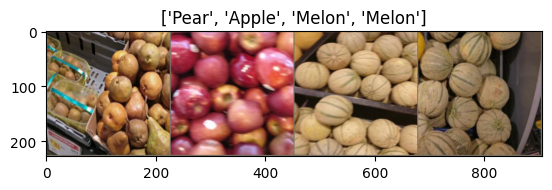

In [9]:
def imshow(inp, title=None):
    """Display image for Tensor."""
    inp = inp.numpy().transpose((1, 2, 0))
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1)
    plt.imshow(inp)
    if title is not None:
        plt.title(title)
    plt.pause(0.001)  # pause a bit so that plots are updated


# Get a batch of training data
inputs, classes = next(iter(dataloaders['train']))

# Make a grid from batch
out = torchvision.utils.make_grid(inputs)

imshow(out, title=[class_names[x] for x in classes])

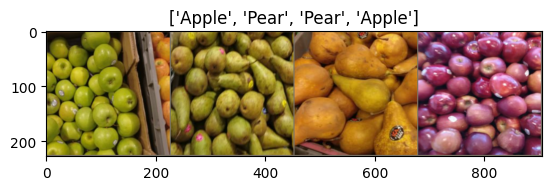

In [10]:
# Versión en la que muevo los tensores a la CPU (para evitar error en el 'Train and evaluate')

def imshow(inp, title=None):
    """Display image for Tensor."""
    inp = inp.numpy().transpose((1, 2, 0))
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1)
    plt.imshow(inp)
    if title is not None:
        plt.title(title)
    plt.pause(0.001)  # pause a bit so that plots are updated



# Get a batch of training data
inputs, classes = next(iter(dataloaders['train']))

# Move tensors to CPU
inputs = inputs.cpu()
classes = classes.cpu()

# Make a grid from batch
out = torchvision.utils.make_grid(inputs)

imshow(out, title=[class_names[x] for x in classes])

## Training the model

Now, let's write a general function to train a model. Here, we will
illustrate:

-  Scheduling the learning rate
-  Saving the best model

In the following, parameter ``scheduler`` is an LR scheduler object from
``torch.optim.lr_scheduler``.



In [11]:
def train_model(model, criterion, optimizer, scheduler, num_epochs=25):
    since = time.time()

    # Create a temporary directory to save training checkpoints
    with TemporaryDirectory() as tempdir:
        best_model_params_path = os.path.join(tempdir, 'best_model_params.pt')

        torch.save(model.state_dict(), best_model_params_path)
        best_acc = 0.0

        for epoch in range(num_epochs):
            print(f'Epoch {epoch}/{num_epochs - 1}')
            print('-' * 10)

            # Each epoch has a training and validation phase
            for phase in ['train', 'val']:
                if phase == 'train':
                    model.train()  # Set model to training mode
                else:
                    model.eval()   # Set model to evaluate mode

                running_loss = 0.0
                running_corrects = 0

                # Iterate over data.
                for inputs, labels in dataloaders[phase]:
                    inputs = inputs.to(device)
                    labels = labels.to(device)

                    # zero the parameter gradients
                    optimizer.zero_grad()

                    # forward
                    # track history if only in train
                    with torch.set_grad_enabled(phase == 'train'):
                        outputs = model(inputs)
                        _, preds = torch.max(outputs, 1)
                        loss = criterion(outputs, labels)

                        # backward + optimize only if in training phase
                        if phase == 'train':
                            loss.backward()
                            optimizer.step()

                    # statistics
                    running_loss += loss.item() * inputs.size(0)
                    running_corrects += torch.sum(preds == labels.data)
                if phase == 'train':
                    scheduler.step()

                epoch_loss = running_loss / dataset_sizes[phase]
                epoch_acc = running_corrects.double() / dataset_sizes[phase]

                print(f'{phase} Loss: {epoch_loss:.4f} Acc: {epoch_acc:.4f}')

                # deep copy the model
                if phase == 'val' and epoch_acc > best_acc:
                    best_acc = epoch_acc
                    torch.save(model.state_dict(), best_model_params_path)

            print()

        time_elapsed = time.time() - since
        print(f'Training complete in {time_elapsed // 60:.0f}m {time_elapsed % 60:.0f}s')
        print(f'Best val Acc: {best_acc:4f}')

        # load best model weights
        model.load_state_dict(torch.load(best_model_params_path))
    return model

### Visualizing the model predictions

Generic function to display predictions for a few images




In [12]:
def visualize_model(model, num_images=6):
    was_training = model.training
    model.eval()
    images_so_far = 0
    fig = plt.figure()

    with torch.no_grad():
        for i, (inputs, labels) in enumerate(dataloaders['val']):
            inputs = inputs.to(device)
            labels = labels.to(device)

            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)

            for j in range(inputs.size()[0]):
                images_so_far += 1
                ax = plt.subplot(num_images//2, 2, images_so_far)
                ax.axis('off')
                ax.set_title(f'predicted: {class_names[preds[j]]}')
                imshow(inputs.cpu().data[j])

                if images_so_far == num_images:
                    model.train(mode=was_training)
                    return
        model.train(mode=was_training)

## Finetuning the ConvNet

Load a pretrained model and reset final fully connected layer.




In [13]:
model_ft = models.resnet18(weights='IMAGENET1K_V1')
num_ftrs = model_ft.fc.in_features
# Here the size of each output sample is set to 2.
# Alternatively, it can be generalized to ``nn.Linear(num_ftrs, len(class_names))``.
model_ft.fc = nn.Linear(num_ftrs, 5)

model_ft = model_ft.to(device)

criterion = nn.CrossEntropyLoss()

# Observe that all parameters are being optimized
optimizer_ft = optim.SGD(model_ft.parameters(), lr=0.001, momentum=0.9)

# Decay LR by a factor of 0.1 every 7 epochs
exp_lr_scheduler = lr_scheduler.StepLR(optimizer_ft, step_size=7, gamma=0.1)

Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth
100%|██████████| 44.7M/44.7M [00:00<00:00, 54.7MB/s]


### Train and evaluate

It should take around 15-25 min on CPU. On GPU though, it takes less than a
minute.




In [14]:
model_ft = train_model(model_ft, criterion, optimizer_ft, exp_lr_scheduler,
                       num_epochs=25)

Epoch 0/24
----------
train Loss: 0.9902 Acc: 0.6044
val Loss: 0.8603 Acc: 0.7544

Epoch 1/24
----------
train Loss: 0.6327 Acc: 0.7659
val Loss: 1.5503 Acc: 0.6667

Epoch 2/24
----------
train Loss: 0.6926 Acc: 0.7689
val Loss: 0.1734 Acc: 0.9474

Epoch 3/24
----------
train Loss: 0.4162 Acc: 0.8607
val Loss: 0.5729 Acc: 0.7719

Epoch 4/24
----------
train Loss: 0.5125 Acc: 0.8119
val Loss: 0.4590 Acc: 0.8246

Epoch 5/24
----------
train Loss: 0.3887 Acc: 0.8593
val Loss: 0.4049 Acc: 0.9123

Epoch 6/24
----------
train Loss: 0.4348 Acc: 0.8548
val Loss: 0.4484 Acc: 0.8246

Epoch 7/24
----------
train Loss: 0.3092 Acc: 0.8874
val Loss: 0.1666 Acc: 0.9298

Epoch 8/24
----------
train Loss: 0.2673 Acc: 0.9259
val Loss: 0.1926 Acc: 0.9298

Epoch 9/24
----------
train Loss: 0.2063 Acc: 0.9259
val Loss: 0.1672 Acc: 0.9298

Epoch 10/24
----------
train Loss: 0.1980 Acc: 0.9333
val Loss: 0.1917 Acc: 0.9298

Epoch 11/24
----------
train Loss: 0.1698 Acc: 0.9481
val Loss: 0.1753 Acc: 0.9298

Ep

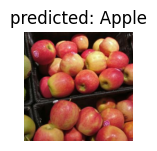

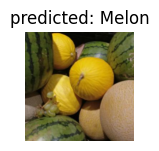

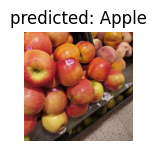

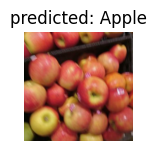

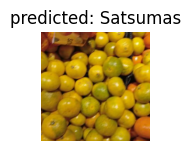

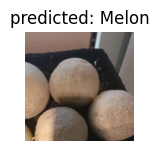

In [15]:
visualize_model(model_ft)

## ConvNet as fixed feature extractor

Here, we need to freeze all the network except the final layer. We need
to set ``requires_grad = False`` to freeze the parameters so that the
gradients are not computed in ``backward()``.

You can read more about this in the documentation
[here](https://pytorch.org/docs/notes/autograd.html#excluding-subgraphs-from-backward)_.




In [16]:
model_conv = torchvision.models.resnet18(weights='IMAGENET1K_V1')
for param in model_conv.parameters():
    param.requires_grad = False

# Parameters of newly constructed modules have requires_grad=True by default
num_ftrs = model_conv.fc.in_features
model_conv.fc = nn.Linear(num_ftrs, 5)

model_conv = model_conv.to(device)

criterion = nn.CrossEntropyLoss()

# Observe that only parameters of final layer are being optimized as
# opposed to before.
optimizer_conv = optim.SGD(model_conv.fc.parameters(), lr=0.001, momentum=0.9)

# Decay LR by a factor of 0.1 every 7 epochs
exp_lr_scheduler = lr_scheduler.StepLR(optimizer_conv, step_size=7, gamma=0.1)

### Train and evaluate

On CPU this will take about half the time compared to previous scenario.
This is expected as gradients don't need to be computed for most of the
network. However, forward does need to be computed.




In [17]:
model_conv = train_model(model_conv, criterion, optimizer_conv,
                         exp_lr_scheduler, num_epochs=25)

Epoch 0/24
----------
train Loss: 1.1165 Acc: 0.5674
val Loss: 0.5559 Acc: 0.7719

Epoch 1/24
----------
train Loss: 0.8617 Acc: 0.6681
val Loss: 0.4162 Acc: 0.8772

Epoch 2/24
----------
train Loss: 0.7425 Acc: 0.7200
val Loss: 0.5352 Acc: 0.7719

Epoch 3/24
----------
train Loss: 0.6367 Acc: 0.7585
val Loss: 0.4841 Acc: 0.8421

Epoch 4/24
----------
train Loss: 0.6503 Acc: 0.7452
val Loss: 0.4516 Acc: 0.8070

Epoch 5/24
----------
train Loss: 0.5412 Acc: 0.8059
val Loss: 0.4779 Acc: 0.8421

Epoch 6/24
----------
train Loss: 0.5539 Acc: 0.7956
val Loss: 0.4379 Acc: 0.8596

Epoch 7/24
----------
train Loss: 0.4707 Acc: 0.8370
val Loss: 0.4376 Acc: 0.8421

Epoch 8/24
----------
train Loss: 0.4702 Acc: 0.8252
val Loss: 0.3947 Acc: 0.7895

Epoch 9/24
----------
train Loss: 0.4650 Acc: 0.8281
val Loss: 0.4183 Acc: 0.8596

Epoch 10/24
----------
train Loss: 0.4701 Acc: 0.8133
val Loss: 0.4150 Acc: 0.8596

Epoch 11/24
----------
train Loss: 0.4928 Acc: 0.8148
val Loss: 0.3706 Acc: 0.8947

Ep

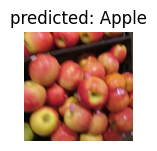

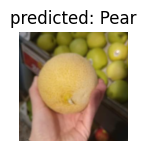

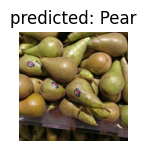

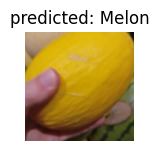

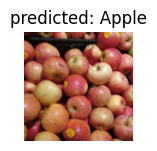

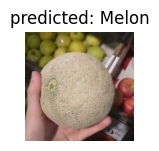

In [18]:
visualize_model(model_conv)

plt.ioff()
plt.show()

## Inference on custom images

Use the trained model to make predictions on custom images and visualize
the predicted class labels along with the images.




In [19]:
# Define the transforms
transform = transforms.Compose([
    transforms.Resize(256),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

# Create a CustomImageDataset
dataset = CustomImageDataset(df_images, transform=transform)

In [20]:
def visualize_model_predictions(model, dataset, idx):
    was_training = model.training
    model.eval()

    # Get the image and label from the dataset
    image, label = dataset[idx]
    image = image.to(device).unsqueeze(0)

    with torch.no_grad():
        outputs = model(image)
        _, preds = torch.max(outputs, 1)

        ax = plt.subplot(2,2,1)
        ax.axis('off')
        ax.set_title(f'Predicted: {dataset.classes[preds[0]]}')
        imshow(image.cpu().data[0])

    model.train(mode=was_training)

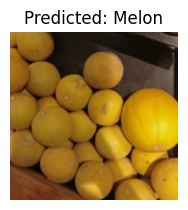

In [21]:
# Choose an index of an image in your dataset
idx = 600  # replace with the index of the image you want to predict

# Call the function with your model and dataset
visualize_model_predictions(model_conv, dataset, idx)